# EDA

For EDA I have two missions:
1. Explore my data in to better formulate my preprocessing and modeling steps
2. Explain relationships and uncovers insights for the Austin Animal Shelters.



For preprocessing already have a few hunches from my cleaning that I want to chase down:
1. Many intake variables are strongly correlated to animal type, for modeling sake adding all of them might be redundant to include features that have strong correlations. This could indicate that creating new features, using PCA, or dropping is needed.
2. Seasonality might count for something, adoptions might rise for animals taken in near or around Christmas.
3. Understand popular breeds and colors, could I break this down into embeddings for my modeling? Is there any salient relationship there?
4. Is my data balanced between adoption and non-adoption? If not is it constant through animal type?


In [59]:
import folium
from folium.plugins import HeatMap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import re
import string
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud 
import statsmodels.formula.api as smf
import os
try:
    os.chdir('./Animal_Adoption_ML_Python/')
except FileNotFoundError:
    pass
#https://github.com/thomaskbrown18/pet_adoption_ML_proj

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

sns.set(font_scale = 2)
sns.set_palette('muted')
sns.set_style(style='darkgrid')


In [60]:
df = pd.read_csv('cleaned_df')
geocoded_df = pd.read_csv('geocoded_locations.csv')
dog_df = pd.read_csv('dog_df')
cat_df = pd.read_csv('cat_df')

## Where are animals found?
I create an interactive heat map using folium. I did geocoding vio the google map API.

*This map wont appear on github. For that reason I make the map again using pyplot \
**I only geocoded a few locations as this is a paid service.

In [61]:
def generateBaseMap(default_location=[30, -97.733330], default_zoom_start=10):
    base_map = folium.Map(location=default_location,
                          control_scale=True, zoom_start=default_zoom_start)
    return base_map


basemap = generateBaseMap()

folium.TileLayer('cartodbpositron').add_to(basemap)
folium.Marker(location=[30.2527847, -97.6926073],
              popup='Austin Animal Shelter',
              icon=folium.Icon(color='green', icon='info-sign')).add_to(basemap)
HeatMap(data=geocoded_df[['latitude', 'longitude']].groupby(['latitude', 'longitude']).sum(
).reset_index().values.tolist(), radius=9, max_zoom=13, name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap


# Who gets adopted?

This comes down to a number of questions, looking across our features:

- How does each animal type fare?
- How long does it typically take for an outcome to occur?
- What features relate to adoption strongly? 
- Do seasons play a part?
- Popular breeds/colors/animal types by days to adopt or other outcome?


finish: 
1. sex_upon_intake
3. intake_count

First we can see that we're working with 148k animals, where more than half are dogs. Moreover, most dogs get adopted, skewing our overall adoption rate closer to one. 

While this skew isn't intense, we see imbalances across groups, especially with dogs being adopted most of the time. 

In [62]:
df_mean = (df[['adopted', 'rehomed_in_30_days', 'animal_type']]
           .groupby('animal_type').mean().reset_index()
           .append(df[['adopted', 'rehomed_in_30_days']].mean(), ignore_index=True)
           .fillna('All')
           .melt(id_vars=['animal_type'], value_vars=['adopted', 'rehomed_in_30_days'])
           .replace({'adopted': 'Adopted', 'rehomed_in_30_days': 'Adopted ≤ 30 Days'})
           .sort_values('animal_type')
           .round(2)
)

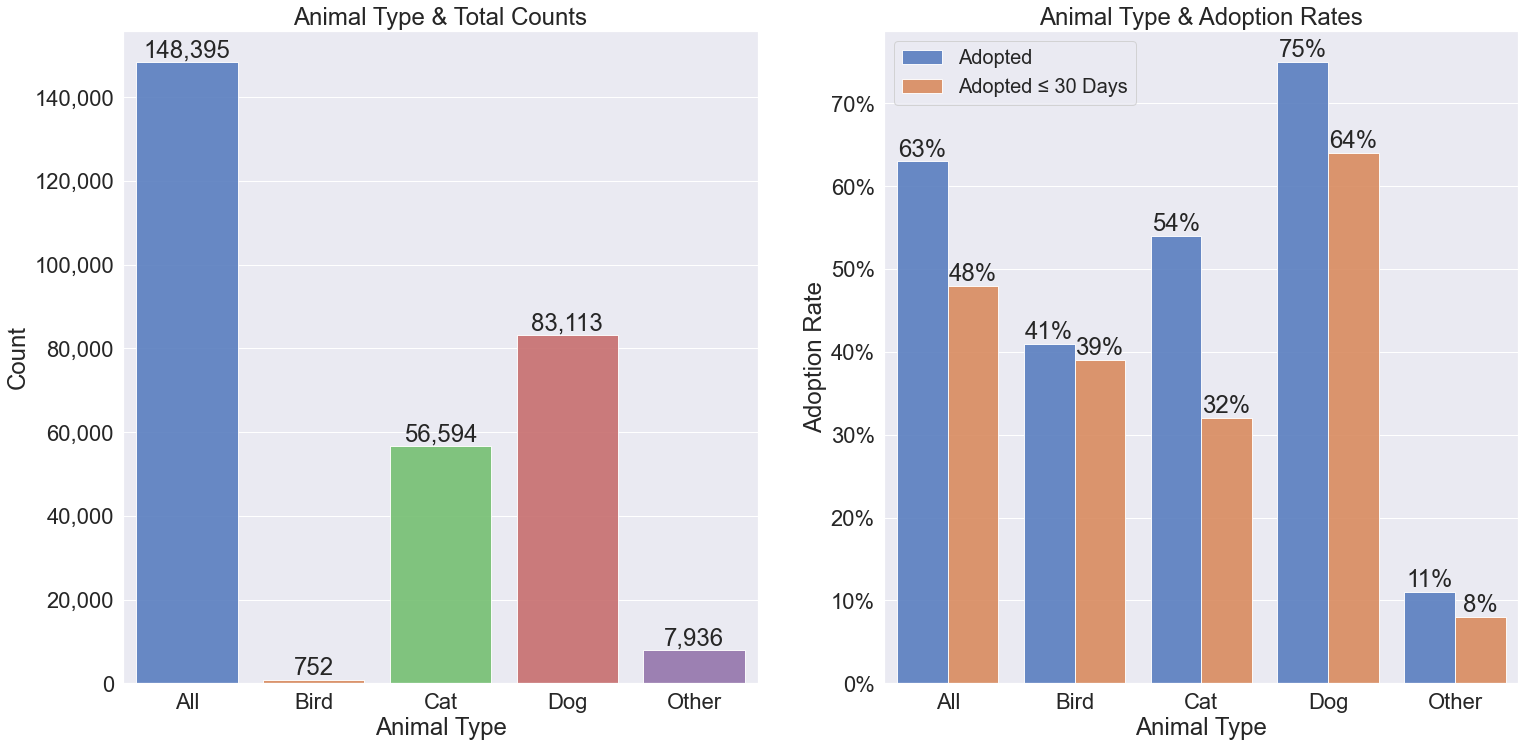

In [63]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,12))
#plot
a = sns.barplot(x='animal_type', y='value', hue='variable',
            data=df_mean, 
            dodge=True, alpha=0.9, ax=ax2)

b = sns.countplot(x='animal_type'
              ,data=df.append(df.assign(animal_type='All'))
              , dodge=True, ax=ax1, alpha=0.9, order = ['All', 'Bird', 'Cat', 'Dog', 'Other'])
#Set titles
ax2.set(ylabel='Adoption Rate', xlabel = 'Animal Type', title='Animal Type & Adoption Rates')
ax1.set(ylabel='Count', xlabel = 'Animal Type', title='Animal Type & Total Counts')
ax2.legend(title='', fontsize='small')

#change bar and ticks to commas and percents
for container in ax1.containers:
    ax1.bar_label(container, labels=[f'{h:,.0f}' for h in container.datavalues])
for container in ax2.containers:
    ax2.bar_label(container, labels=[f'{h*100:,.0f}%' for h in container.datavalues])

ax1.set_yticklabels([f'{x:,.0f}' for x in ax1.get_yticks()]);
ax2.set_yticklabels([f'{h*100:,.0f}%' for h in ax2.get_yticks()]);


We can see that many animals, on average, get adopted within a year. We seem to be dealing with some strong outliers as well. These don't seem to be true data point but I must be mindful when it comes to standardization down the road as these values are mess with my preprocessing.

Median/Mean Days until Outcome:
                       mean  median
outcome_type                      
adopt               343.67   294.5
deceased            153.24    95.0
transfer_other_org  175.66   140.5
Total Animals in Pound Over 2 Years: 53


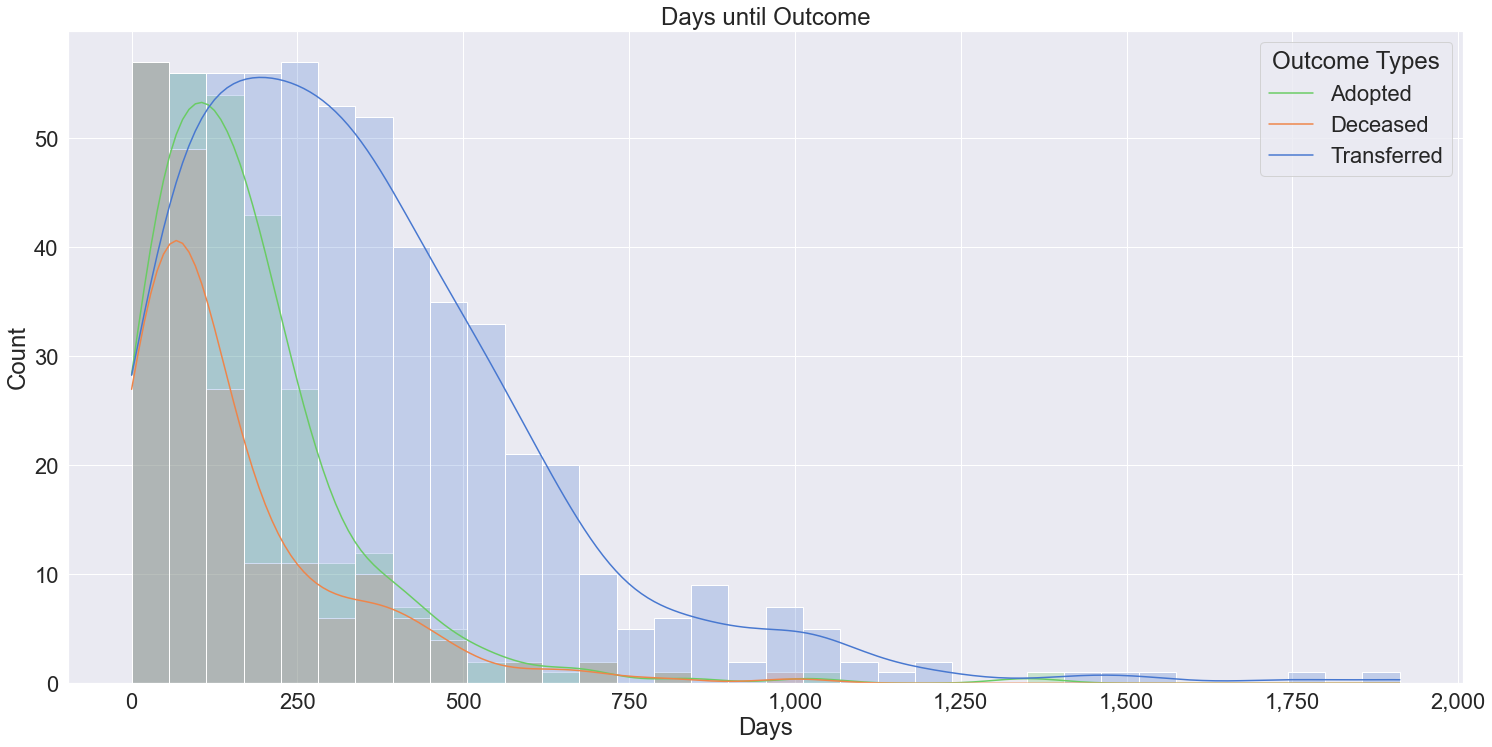

In [64]:
test = df.groupby(['days', 'outcome_type'])['adopted'].count().div(df.shape[0]).reset_index().melt(id_vars=['days', 'outcome_type'])

plt.subplots(figsize=(25,12))
ax = sns.histplot(x='days',hue='outcome_type',data=test, alpha=0.25, hue_order=['adopt', 'deceased', 'transfer_other_org'], kde=True);
ax.legend(labels=['Adopted', 'Deceased', 'Transferred'], title='Outcome Types')
ax.set(xlabel='Days', title='Days until Outcome')
ax.set_xticklabels([f'{x:,.0f}' for x in ax.get_xticks()]);
print('Median/Mean Days until Outcome:\n', test.groupby('outcome_type')['days'].agg(['mean', 'median']).round(2))
print('Total Animals in Pound Over 2 Years:',df.loc[df.days>730].shape[0])


Additionally it seems that younger animals get adopted or transferred to another shelter more often, especially for Cats & Dogs.

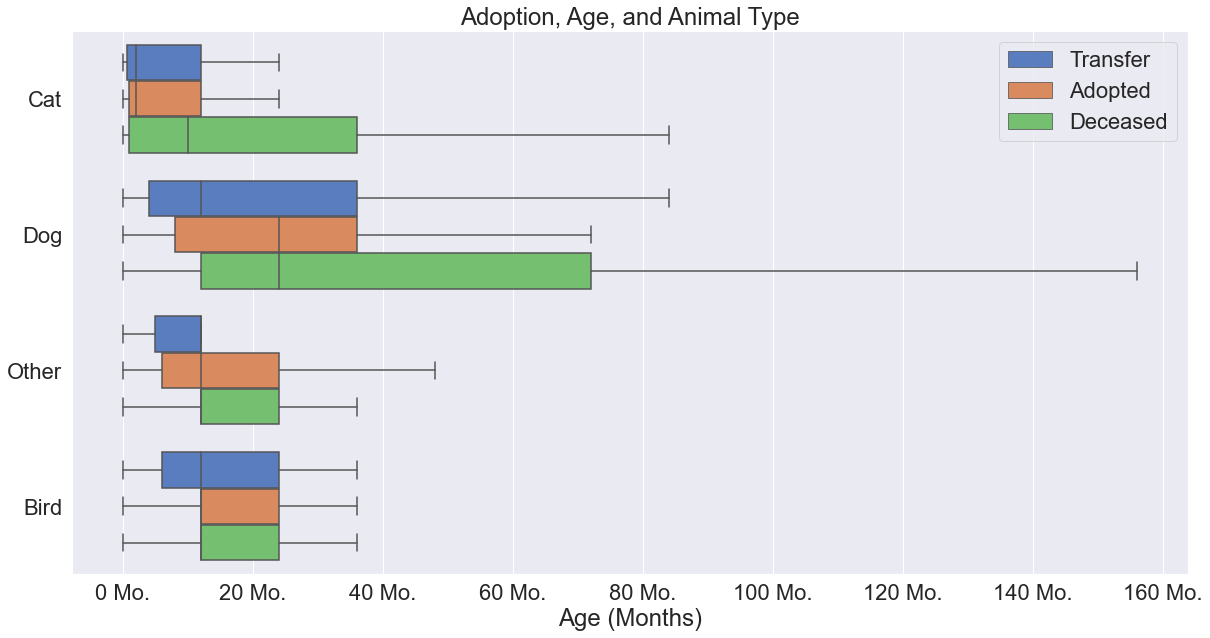

In [65]:
fig = plt.subplots(figsize=(20,10))
ax = sns.boxplot(y='animal_type', x="age", data=df,
                    hue='outcome_type', showfliers=False)

ax.set(ylabel= '', xlabel='Age (Months)', title = 'Adoption, Age, and Animal Type');
ax.legend(handles=ax.legend_.legendHandles, labels=['Transfer', 'Adopted', 'Deceased'])
ax.set_xticklabels([f'{x:.0f} Mo.' for x in ax.get_xticks()]);


Intake Type shows follows a typical pattern: being brought in for normal reasons means your adoption chances are strong, but coming in as wildlife or to be put down changes the animal's outcome.

Intake condition however greatly determines if an animal will be adopted.

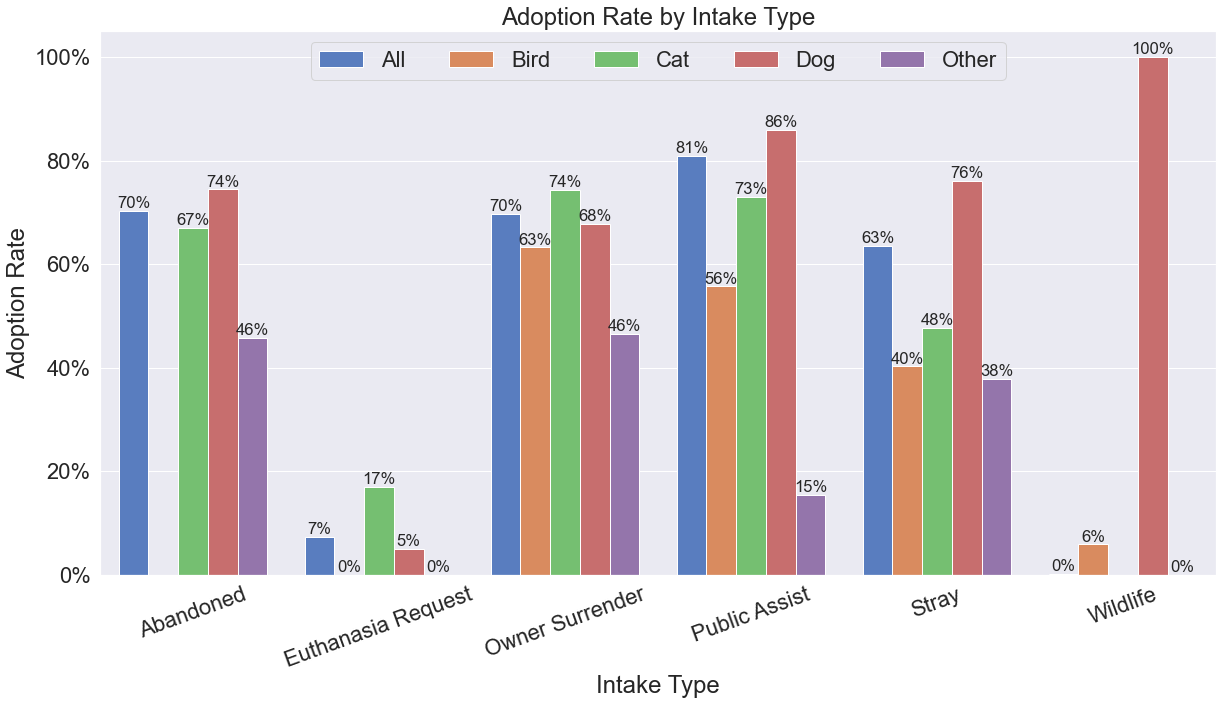

In [66]:
fig = plt.subplots(figsize=(20,10))
ax = sns.barplot(hue='animal_type', y='adopted', x='intake_type', data=df.append(df.assign(animal_type = 'All')).groupby(['animal_type', 'intake_type'])[['adopted', 'rehomed_in_30_days']].mean().reset_index())
ax.set(xlabel='Intake Type', ylabel = 'Adoption Rate', title='Adoption Rate by Intake Type')
#change bar and ticks to commas and percents
ax.legend(handles=ax.legend_.legendHandles, labels=['All', 'Bird', 'Cat', 'Dog', 'Other'], loc='best', ncol=5)
for container in ax.containers:
    ax.bar_label(container, labels=[f'{h*100:,.0f}%' for h in container.datavalues], size='x-small')
ax.set_yticklabels([f'{h*100:,.0f}%' for h in ax.get_yticks()])
ax.tick_params(axis = 'x',rotation=20);

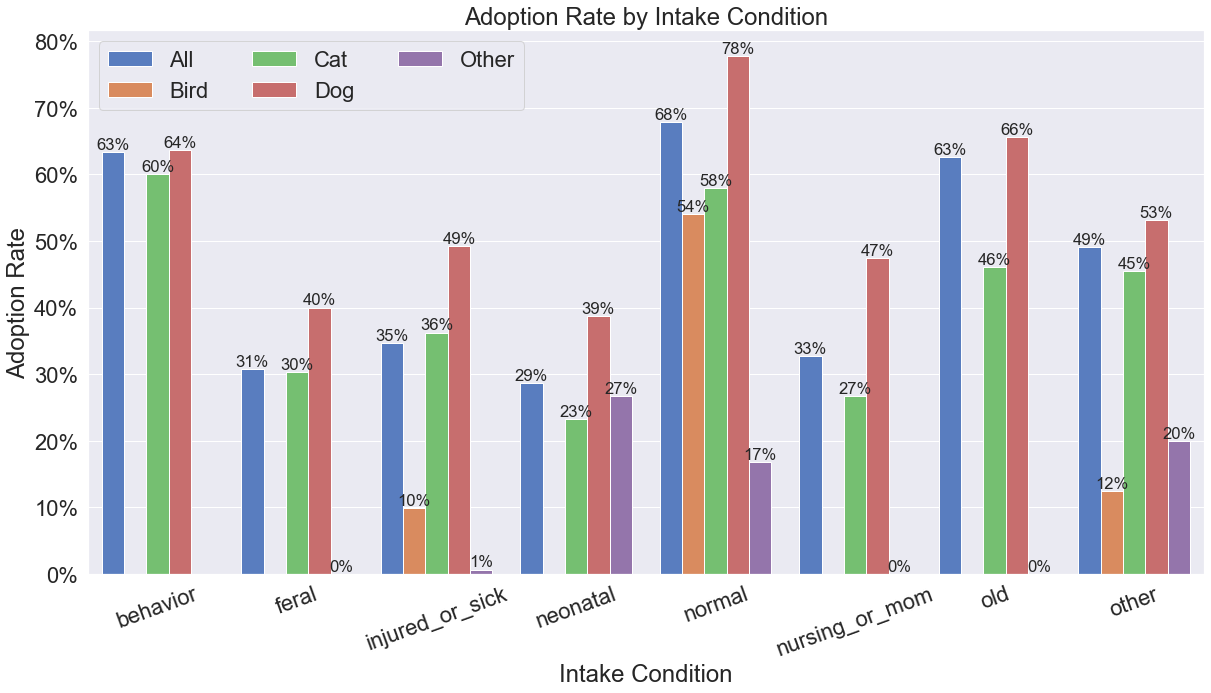

In [67]:
fig = plt.subplots(figsize=(20,10))
ax = sns.barplot(hue='animal_type', y='adopted', x='intake_condition', data=df.append(df.assign(animal_type = 'All')).groupby(['animal_type', 'intake_condition'])[['adopted', 'rehomed_in_30_days']].mean().reset_index())
ax.set(xlabel='Intake Condition', ylabel = 'Adoption Rate', title='Adoption Rate by Intake Condition')
#change bar and ticks to commas and percents
ax.legend(handles=ax.legend_.legendHandles, labels=['All', 'Bird', 'Cat', 'Dog', 'Other'], loc='upper left', ncol=3)
for container in ax.containers:
    ax.bar_label(container, labels=[f'{h*100:,.0f}%' for h in container.datavalues], size='x-small')
ax.set_yticklabels([f'{h*100:,.0f}%' for h in ax.get_yticks()])
ax.tick_params(axis = 'x',rotation=20);


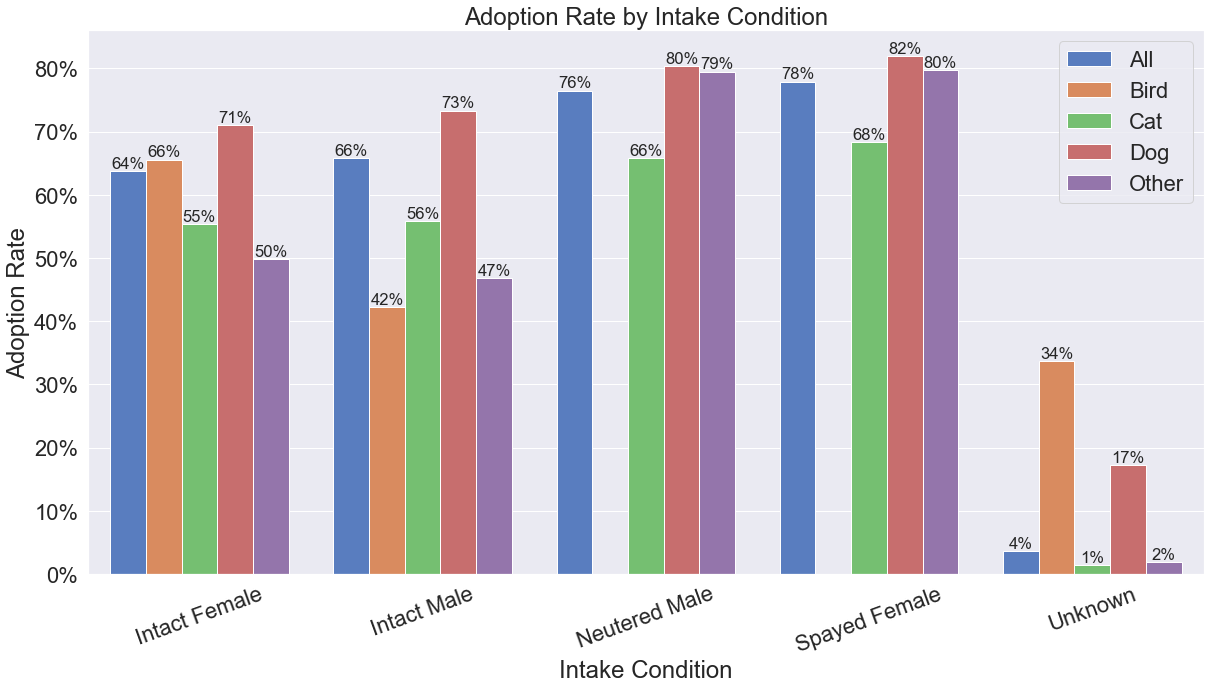

In [68]:
fig = plt.subplots(figsize=(20,10))
ax = sns.barplot(hue='animal_type', y='adopted', x='sex_upon_intake', data=df.append(df.assign(animal_type = 'All')).groupby(['animal_type', 'sex_upon_intake'])[['adopted', 'rehomed_in_30_days']].mean().reset_index())
ax.set(xlabel='Intake Condition', ylabel = 'Adoption Rate', title='Adoption Rate by Intake Condition')
#change bar and ticks to commas and percents
ax.legend(handles=ax.legend_.legendHandles, labels=['All', 'Bird', 'Cat', 'Dog', 'Other'], loc='upper right', ncol=1)
for container in ax.containers:
    ax.bar_label(container, labels=[f'{h*100:,.0f}%' for h in container.datavalues], size='x-small')
ax.set_yticklabels([f'{h*100:,.0f}%' for h in ax.get_yticks()])
ax.tick_params(axis = 'x',rotation=20);


Seasonally animals come in most in the summer months, while many are adopted in the late summer/early fall.

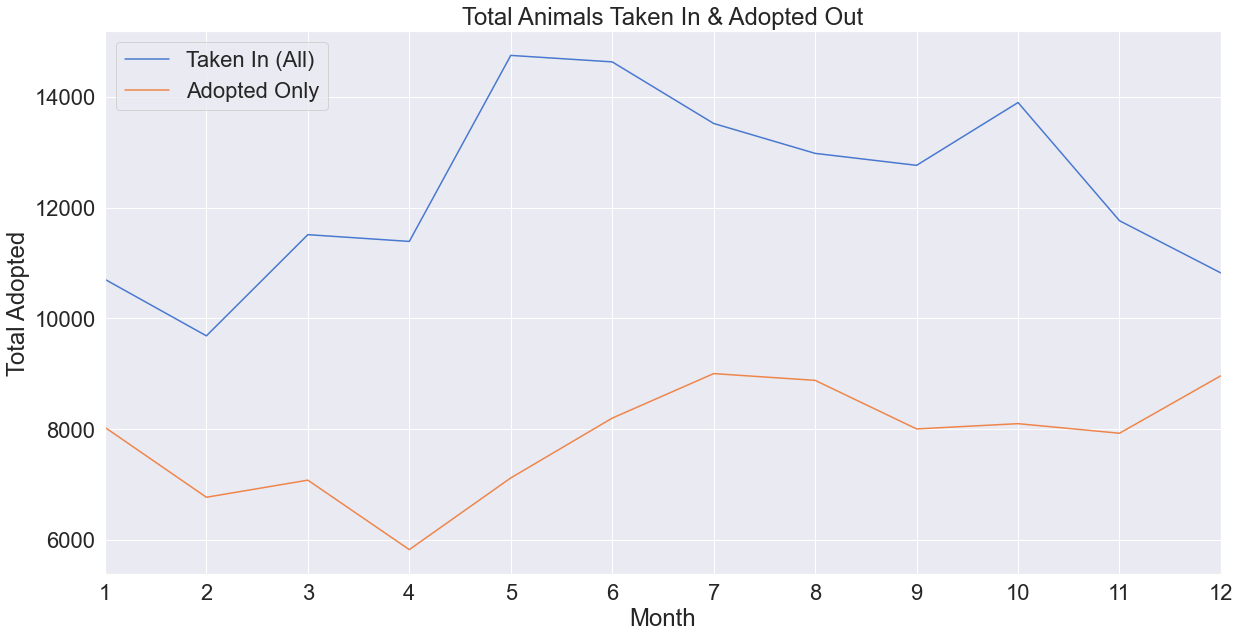

In [69]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='intake_month', y='counter', data=df.groupby('intake_month')['animal_id'].agg(counter = 'count')
, ax=ax, label='Intake')
sns.lineplot(x='outcome_month', y='counter', data=df.loc[df.adopted==1].groupby('outcome_month')['animal_id'].agg(counter = 'count')
, ax=ax, label='Outcome')
ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set(xlabel='Month', ylabel='Total Adopted', title='Total Animals Taken In & Adopted Out')
ax.legend(labels=['Taken In (All)', 'Adopted Only'])


When it comes to breeds we have a lot of variation! Much of it comes down to the same animal but 'Mix' is included or not. It's hard to say if this matters (chicken vs chicken mix). But maybe we can do something about it in preprocessing?

Moreover we have extremely sparse breeds, so it might not be too informative to split our columns out into 2819 rows. 

I am thinking of embedding these, upsampling, or dropping completely.

In [70]:
dog_df = pd.read_csv('dog_df', index_col=0)
cat_df = pd.read_csv('cat_df', index_col=0)

In [103]:
count_df = df.melt(
    id_vars=["animal_type"],
    value_vars=["breed_one", "breed_two", "color_one", "color_two"],
    value_name="names",
    var_name="ident",
)
count_df = count_df.loc[count_df.names != 'drop']

In [130]:
print('{} Unique Breed Combinations.'.format(df.breed.nunique()))
print('Overall {} average animals containing certain breed, with a median of {}.'.format(count_df.loc[count_df.ident.str.contains('breed')].value_counts().mean().round(2), count_df.loc[count_df.ident.str.contains('breed')].value_counts().median()))
count_df.loc[count_df.ident.str.contains('breed')].groupby('animal_type')['names'].agg(Unique_Values='nunique', Most_Common=pd.Series.mode)

2536 Unique Breed Combinations.
Overall 303.71 average breeds per animal, with a median of 13.0.


,Unique_Values,Most_Common
animal_type,,
Bird,56,chicken
Cat,39,domestic shorthair
Dog,188,pit bull
Other,74,bat


In [131]:
print('{} Unique Color Combinations.'.format(df.color.nunique()))
print('Overall {} average animals containing certain color, with a median of {}.'.format(count_df.loc[count_df.ident.str.contains('color')].value_counts().mean().round(2), count_df.loc[count_df.ident.str.contains('color')].value_counts().median()))
count_df.loc[count_df.ident.str.contains('color')].groupby('animal_type')['names'].agg(Unique_Values='nunique', Most_Common=pd.Series.mode)

626 Unique Color Combinations.
Overall 929.09 average animals containing certain color, with a median of 35.0.


,Unique_Values,Most_Common
animal_type,,
Bird,18,white
Cat,50,white
Dog,41,white
Other,31,brown


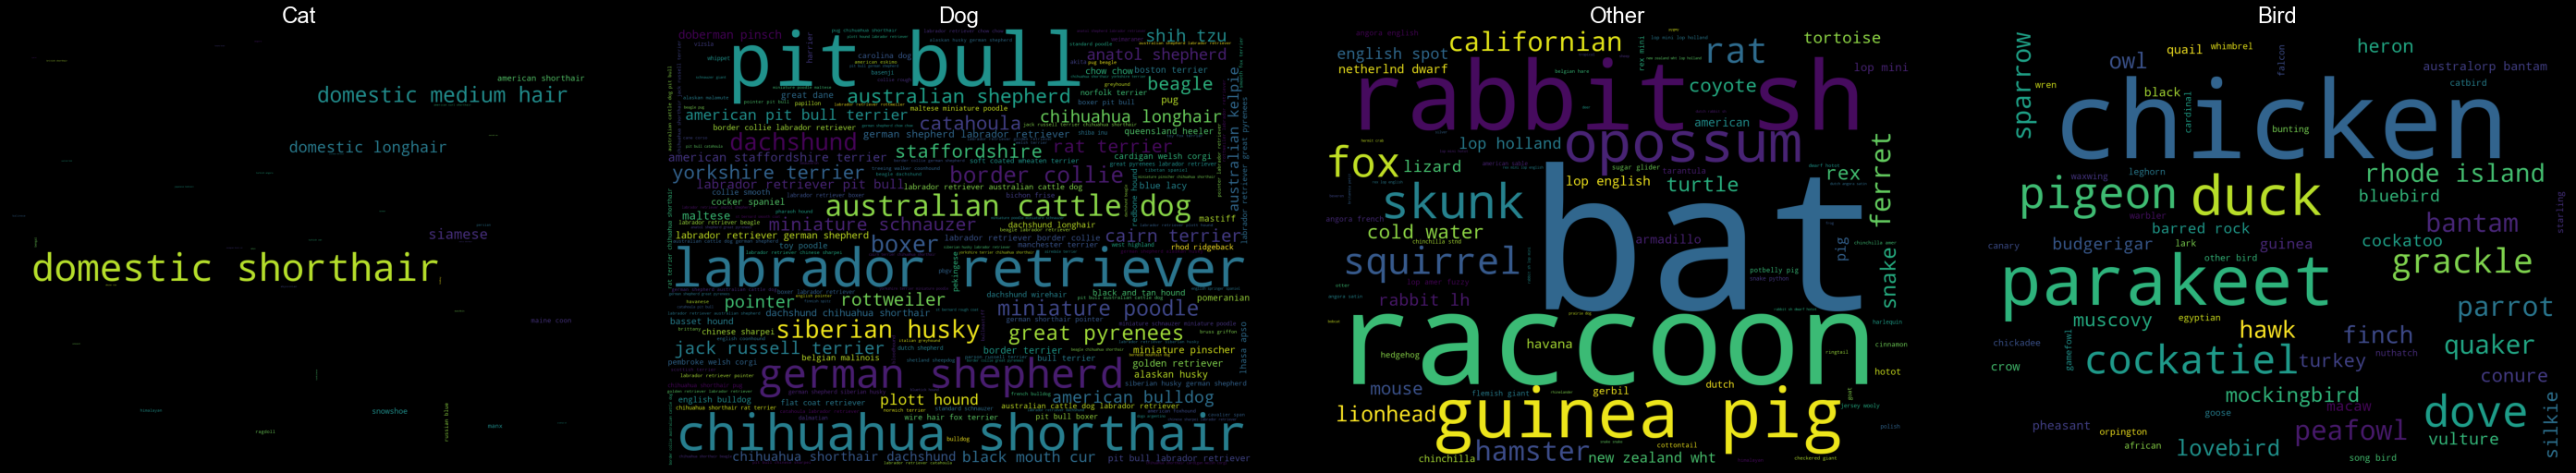

In [106]:
#Show popular names
fig, ax = plt.subplots(1, 4, figsize=(40,40))
plt.tight_layout()
fig.patch.set_facecolor('black') # set background color of figure to black
counter = 0 
for i in df.animal_type.unique().tolist():
    if i == 'Dog':
        texts = dog_df.loc[dog_df.animal_type == i]['breeds'].value_counts().to_dict()
    if i == 'Cat':
        texts = cat_df.loc[cat_df.animal_type == i]['breeds'].value_counts().to_dict()
    else:
        texts = df.loc[df.animal_type == i]['breed'].value_counts().to_dict()
    cloud = WordCloud(width=1440, height=1080).generate_from_frequencies(texts)
    ax[counter].imshow(cloud)
    ax[counter].axis('off')
    ax[counter].set_title(i, color='white')
    counter +=1


Does being mixed matter? Lets check it out:

It seems like it does by doing chi-squared tests on adoption status and if the animal is mixed, but this is extremely hard to distinguish, but worthwhile to keep in our predictions if we can't use breed by itself.

In [107]:
df.groupby(['animal_type','mixed'])[['adopted','rehomed_in_30_days']].mean()


adopted  rehomed_in_30_days
animal_type mixed                              
Bird        0      0.436275            0.416667
            1      0.383721            0.366279
Cat         0      0.594920            0.342554
            1      0.514832            0.307780
Dog         0      0.722877            0.627905
            1      0.754706            0.637801
Other       0      0.127710            0.106981
            1      0.089864            0.059107

In [108]:
for i in df.animal_type.unique():
    contingency_table = pd.crosstab(df.loc[df.animal_type==i]['adopted'], df.loc[df.animal_type==i]['mixed'])
    from scipy.stats import chi2_contingency
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(i, " p-value:", p.round(3))

Cat  p-value: 0.0
Dog  p-value: 0.0
Other  p-value: 0.0
Bird  p-value: 0.166


How about having a name available? Is it correlated with animal type? does it associate with being adopted?

Maybe not surprisingly its common for certain animal types to have names over others, therefore I run an OLS to isolate the variation explained in adoption by solely having a name available, we see significant results, atleast suggesting that the presence of a name in itself could explain adoption status.

In [77]:
df.groupby(['animal_type','name_avail'])[['adopted']].agg(['count', 'mean']).sort_values('animal_type')


adopted          
                         count      mean
animal_type name_avail                  
Bird        0.0            572  0.361888
            1.0            180  0.572222
Cat         0.0          22682  0.225818
            1.0          33912  0.746815
Dog         0.0          13295  0.516961
            1.0          69818  0.793134
Other       0.0           6667  0.025499
            1.0           1269  0.553191

In [78]:
smf.ols(formula = 'adopted ~ animal_type + name_avail', data=df).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                adopted   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                 1.174e+04
Date:                Mon, 03 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:37:41   Log-Likelihood:                -81883.
No. Observations:              148395   AIC:                         1.638e+05
Df Residuals:                  148390   BIC:                         1.638e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3131      0.015     20.416      0.000       0.283       0.343
animal_type[T.Cat]      -0.0233      0.015     -1.509      0.131      -0.054       0.007
animal_type[T.Dog]       0.0879      0.015      5.679      0.000       0.058       0.118
animal_type[T.Other]    -0.2694      0.016    -16.806      0.000      -0.301      -0.238
name_avail               0.4143      0.003    158.891      0.000       0.409       0.419
==============================================================================
Omnibus:                    11650.330   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11914.349
Skew:                          -0.646   Prob(JB):                         0.00
Kurtosis:                       2.493   Cond. No.                         40.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Lastly, how does how frequently do animals get brought in, how does it affect their adoption rates, and could it be a good predictor?

Generally we see as mass of animals only being brought in once of twice, 

In [79]:
df.groupby('intake_count')['adopted'].agg(['count', 'mean']).reset_index()


,intake_count,count,mean
0,1,132983,0.610710
1,2,11789,0.810925
2,3,2442,0.840704
3,4,710,0.877465
4,5,237,0.907173
5,6,106,0.915094
6,7,59,0.881356
7,8,24,0.833333
8,9,11,1.000000
9,10,4,1.000000


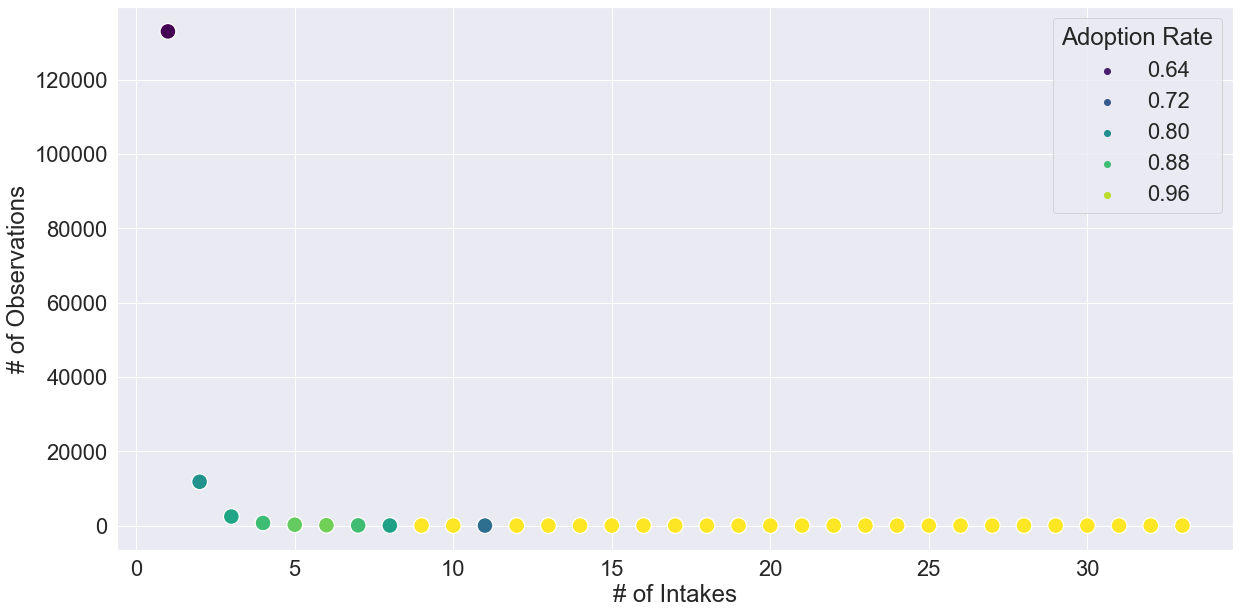

In [120]:
intake_df = df.groupby('intake_count')['adopted'].agg(['count', 'mean']).reset_index()
fig = plt.subplots(figsize=(20,10))

ax = sns.scatterplot(x='intake_count', y='count', hue='mean', s=250 ,data = intake_df, markers=False, palette='viridis')
ax.set(xlabel='# of Intakes', ylabel='# of Observations');
ax.legend( title='Adoption Rate')